In [74]:
from typing import Dict, List, Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.base import BaseEstimator, is_classifier
from sklearn.calibration import CalibrationDisplay, calibration_curve
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.impute import KNNImputer
from sklearn.inspection import permutation_importance
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler, TargetEncoder, label_binarize
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from yellowbrick.classifier import ConfusionMatrix, ClassificationReport

from fwi_predict.constants import WQ_RANGES
from fwi_predict.wq import get_in_required_range

In [75]:
# Function to create train-test splits for each target
def create_stratified_splits(df, target_cols, test_size=0.2, random_state=42):
    splits = {}
    for target in target_cols:
        # Drop rows with missing target values
        df_clean = df[df[target].astype(bool)]
        
        # Split features and target
        X = df_clean.drop(target_cols, axis=1)
        y = df_clean[target]

        le = LabelEncoder()
        ye = le.fit_transform(y)

        X_train, X_test, y_train, y_test = train_test_split(
          X, ye,
          test_size=test_size,
          random_state=random_state,
          stratify=ye
        )
            
        splits[target] = {
            'X_train': X_train, 'X_test': X_test,
            'y_train': y_train, 'y_test': y_test,
            'label_encoder': le
        }
    
    return splits

In [76]:
# Probably want to change this so that it doesn't use the plot() function
# And more closely matches original CalibrationDisplay interface.
class MulticlassCalibrationDisplay:
    """
    A display for visualizing the calibration curves of a multiclass classification model.
    """

    def __init__(self, prob_true, prob_pred, classes):
        """
        Initialize the CalibrationDisplay.

        Parameters:
        - prob_true (list of arrays): List of true probabilities for each class.
        - prob_pred (list of arrays): List of predicted probabilities for each class.
        - classes (list): List of class labels.
        """
        self.prob_true = prob_true
        self.prob_pred = prob_pred
        self.classes = classes

    @classmethod
    def from_estimator(cls, estimator, X, y, encoder=None, n_bins=10, strategy='uniform'):
        """
        Create a CalibrationDisplay from an estimator.

        Parameters:
        - estimator: A fitted classifier with a `predict_proba` method.
        - X: Feature matrix.
        - y: True labels (already encoded).
        - encoder: Label encoder to get class names. If None, uses estimator.classes_.
        - n_bins: Number of bins for the calibration curve.
        - strategy: Strategy to define the bins ('uniform' or 'quantile').

        Returns:
        - CalibrationDisplay instance.
        """
        if not is_classifier(estimator):
            raise ValueError("The estimator should be a classifier.")

        y_pred_prob = estimator.predict_proba(X)
        classes = encoder.classes_ if encoder is not None else estimator.classes_
        return cls.from_predictions(y, y_pred_prob, classes, n_bins=n_bins, strategy=strategy)

    @classmethod
    def from_predictions(cls, y_true, y_pred_prob, classes, n_bins=10, strategy='uniform'):
        """
        Create a CalibrationDisplay from true labels and predicted probabilities.

        Parameters:
        - y_true: True labels (already encoded).
        - y_pred_prob: Predicted probabilities.
        - classes: List of class labels.
        - n_bins: Number of bins for the calibration curve.
        - strategy: Strategy to define the bins ('uniform' or 'quantile').

        Returns:
        - CalibrationDisplay instance.
        """
        if len(classes) <= 2:
            raise ValueError(
                "For binary classification, use sklearn.calibration.CalibrationDisplay instead. "
                "This class is intended for multiclass calibration."
            )

        y_true_binarized = label_binarize(y_true, classes=range(len(classes)))
        prob_true = []
        prob_pred = []

        for i in range(len(classes)):
            true_class = y_true_binarized[:, i]
            pred_class = y_pred_prob[:, i]

            prob_true_class, prob_pred_class = calibration_curve(
                true_class, pred_class, n_bins=n_bins, strategy=strategy
            )
            prob_true.append(prob_true_class)
            prob_pred.append(prob_pred_class)

        return cls(prob_true, prob_pred, classes)

    def plot(self, ax=None, figsize=(10, 8)):
        """
        Plot calibration curves for each class.

        Parameters:
        - ax: A matplotlib axis object. If None, a new figure and axis are created.
        - figsize (tuple): Size of the plot figure (ignored if ax is provided).
        """
        no_ax_passed = False
        if ax is None:
            fig, ax = plt.subplots(figsize=figsize)
            no_ax_passed = True

        for i, class_label in enumerate(self.classes):
            ax.plot(
                self.prob_pred[i], self.prob_true[i], marker='o', label=f"{class_label}", linewidth=1.5
            )

        ax.plot([0, 1], [0, 1], 'k--', label="Perfectly calibrated")
        ax.set_title("Calibration Curves for Multiclass Classification")
        ax.set_xlabel("Mean predicted probability")
        ax.set_ylabel("Fraction of positives")
        ax.legend(loc="best")
        ax.grid()

        if no_ax_passed:
            plt.show()

In [77]:
models = {
    'Random Forest': {
        'model': RandomForestClassifier(),
        'needs_imputation': True, # Because of best feature selection
        'params': {
            'classifier__n_estimators': [100, 200, 300],
            'classifier__max_depth': [10, 20, None],
            'classifier__min_samples_split': [5, 20]
        }
    },
    'Gradient Boosting': {
        'model': GradientBoostingClassifier(),
        'needs_imputation': True,
        'params': {
            'classifier__n_estimators': [100, 200],
            'classifier__learning_rate': [0.01, 0.1],
            'classifier__max_depth': [3, 7]
        }
    } #,
}


def create_pipeline(model_info,
                    cat_vars: List[str],
                    random_state: int = 42) -> Pipeline:
  """Create a scikit-learn pipeline for preprocessing and model training.
  
  Args:
    model_info: Dictionary containing model configuration
    cat_vars: Column names of categorical features.
    random_state: Random seed for reproducibility
      
  Returns:
    sklearn.pipeline.Pipeline: Configured pipeline
  """
  # Store pipeline steps
  steps = []
  
  # Create column transformer first
  cat_encoder = TargetEncoder(random_state=random_state)
  cat_transform = ColumnTransformer([("categorical", cat_encoder, cat_vars)], remainder='passthrough')
  steps.append(('cat_encoder', cat_transform))

  if model_info['needs_imputation']:
     steps.append(('impute', KNNImputer(n_neighbors=10)))
  
  steps.extend([
    ('scaler', StandardScaler()),
    ('dim_reduction', SelectKBest(score_func=f_classif, k=25)), 
    ('classifier', model_info['model'])
  ])

  return Pipeline(steps)


def plot_feature_importance(X_train, y_train):
    # Feature importance using permutation importance
    rf = RandomForestClassifier(n_estimators=100)
    rf.fit(X_train, y_train)
    
    # Calculate permutation importance
    perm_importance = permutation_importance(rf, X_train, y_train, 
                                             n_repeats=10, n_jobs=-1, random_state=42)
    
    feature_importance = pd.DataFrame({
        'feature': X_train.columns,
        'importance': perm_importance.importances_mean
    }).sort_values('importance', ascending=False)
    
    plt.figure(figsize=(12, 6))
    sns.barplot(data=feature_importance.head(20), x='importance', y='feature')
    plt.title('Top 20 Most Important Features (Permutation Importance)')
    plt.show()
    
    return feature_importance


def train_models(X_train: Union[pd.DataFrame, np.ndarray],
                 y_train: Union[pd.DataFrame, np.ndarray],
                 cat_vars: List[str],
                 folds: int = 5) -> Dict[str, BaseEstimator]:
    results = {}
    
    # Create figure for plotting
    plt.figure(figsize=(10, 6))
    
    for idx, (name, model_info) in enumerate(models.items()):
        print(f"\nTraining {name}...")
        
        # Create pipeline
        param_grid = model_info['params'].copy()
        pipeline = create_pipeline(model_info, cat_vars)
        
        # Create CV object
        cv = StratifiedKFold(n_splits=folds, shuffle=True, random_state=42)
        
        # Define scoring metrics for each class
        scoring = {
            'accuracy': 'accuracy',
            'precision_macro': 'precision_macro',
            'recall_macro': 'recall_macro',
            'f1_macro': 'f1_macro'
        }
        
        # Perform grid search with multiple scoring metrics
        grid_search = GridSearchCV(
          pipeline, param_grid,
          cv=cv, scoring=scoring, 
          refit='accuracy', n_jobs=-1,
          return_train_score=True
        )
        
        # Fit model
        grid_search.fit(X_train, y_train)
        
        # Get best model and score
        best_score = grid_search.best_score_
        best_pipeline = grid_search.best_estimator_
        
        print(f"Best CV accuracy score: {best_score:.3f}")
        
        # Store best model
        results[name] = best_pipeline
        
        # Plot CV scores from grid search results
        plt.subplot(1, 2, idx+1)
        
        # Extract CV results for visualization
        cv_results = pd.DataFrame(grid_search.cv_results_)
        
        # Get scores for best parameters
        # Need to fix this figure.
        best_idx = cv_results['rank_test_accuracy'] == 1
        cv_scores = {
            'Accuracy': cv_results.loc[best_idx, [f'split{i}_test_accuracy' for i in range(folds)]].values[0],
            'Precision': cv_results.loc[best_idx, [f'split{i}_test_precision_macro' for i in range(folds)]].values[0], 
            'Recall': cv_results.loc[best_idx, [f'split{i}_test_recall_macro' for i in range(folds)]].values[0],
        }
        
        # Reshape data for seaborn plotting
        scores_df = pd.DataFrame(cv_scores)
        scores_df = scores_df.reset_index().melt(id_vars='index', var_name='Metric', value_name='Score')
        scores_df['Fold'] = scores_df['index'].map(lambda x: f'Fold {x+1}')
        
        # Create grouped bar plot using seaborn
        sns.barplot(data=scores_df, x='Metric', y='Score', hue='Fold', dodge=True)
        plt.title(f'{name} CV Performance Metrics')
        plt.xticks(rotation=45)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        
    plt.tight_layout()
    plt.show()
    
    return results

# Function to compare model performances
def compare_models(models_dict: Dict[str, BaseEstimator],
                   X_test: Union[pd.DataFrame, np.ndarray],
                   y_test: Union[pd.DataFrame, np.ndarray],
                   encoder: Union[Dict, LabelEncoder] = None) -> None:
    # Create subplots for different visualizations
    fig, axes = plt.subplots(len(models_dict), 3, figsize=(20, 5*len(models_dict)))
    
    for idx, (name, model) in enumerate(models_dict.items()):
        # Confusion Matrix
        cm = ConfusionMatrix(model,
                             ax=axes[idx, 0],
                             encoder=encoder)
        cm.score(X_test, y_test)
        cm.ax.set_title(f'{name} - Confusion Matrix')

        # Classification Report
        cr = ClassificationReport(model,
                                  ax=axes[idx, 1], 
                                  classes=list(reversed(encoder.classes_))) # Hacky fix because function is broken.
        cr.score(X_test, y_test)
        cr.ax.set_title(f'{name} - Classification Report')

        # Calibration Plot
        if len(model.classes_) == 2:
          pos_label = np.where(encoder.classes_ != 'within')[0][0]
          pos_name = [c for c in encoder.classes_ if c != 'within'][0]
          cal_display = CalibrationDisplay.from_estimator(model, X_test,y_test,
                                                          n_bins=10,
                                                          ax=axes[idx, 2],
                                                          pos_label=pos_label,
                                                          name=pos_name)
          axes[idx, 2].grid(False)
        else:
          cal_display = MulticlassCalibrationDisplay.from_estimator(model, X_test, y_test,
                                                                    encoder=encoder)
          cal_display.plot(ax=axes[idx, 2])

        axes[idx, 2].set_title(f'{name} - Calibration Plot')
      
    
    plt.tight_layout()
    plt.show()


In [78]:
predict_df = pd.read_csv("../data/predict_dfs/train/measurements_with_metadata_predict_df.csv")

In [79]:
# Load data and remove columns that we don't want for training
predict_df = pd.read_csv("../data/predict_dfs/train/measurements_with_metadata_predict_df.csv")

predict_df = predict_df.drop(columns=['sample_idx', 'pond_id', 'region',
                                      'farm_id', 'sample_dt', 'geometry'])

# Get parameters for classification problem
predict_df['time_of_day'] = predict_df['morning'].apply(lambda x: 'morning' if x else 'evening')
for param in WQ_RANGES.keys():
  range_name = param.split('_')[0] + '_in_range'
  predict_df[range_name] = get_in_required_range(param, predict_df[param], predict_df['time_of_day'])

predict_df = predict_df.drop(columns='time_of_day')
classify_df = predict_df.loc[:, ~predict_df.columns.isin(WQ_RANGES.keys())]
regress_df = predict_df[predict_df.columns[~predict_df.columns.str.endswith('_in_range')].tolist()]
# predict_df.head()


Processing target: do_in_range


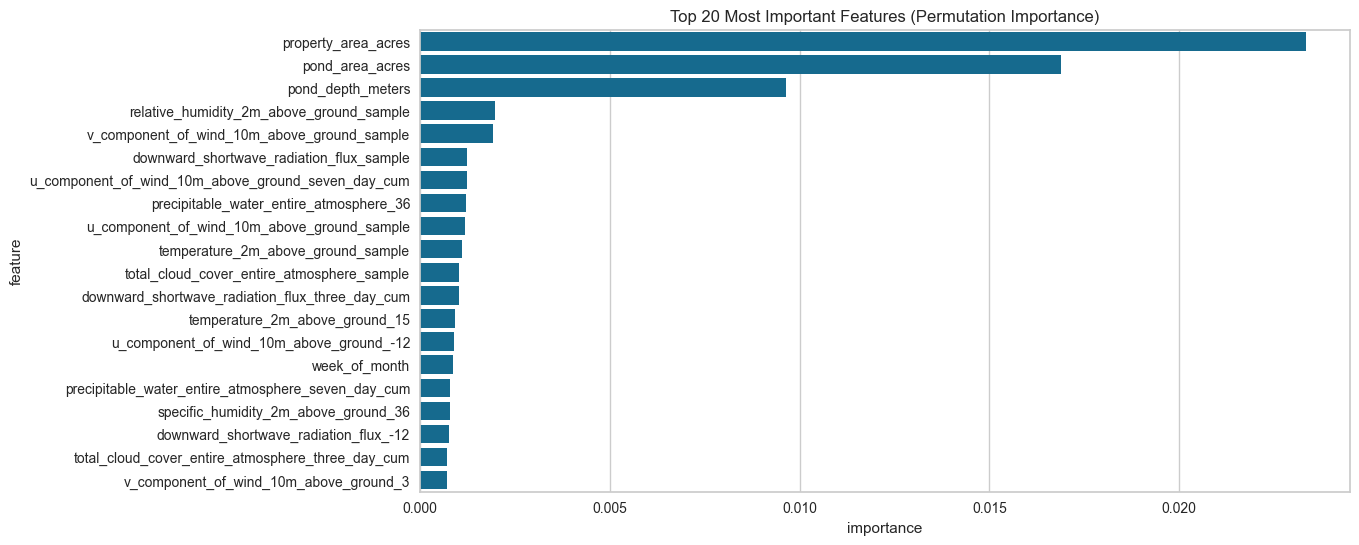


Training Random Forest...


c:\Users\squaade\Documents\Github\fwi-predict\.venv\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [17] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\squaade\Documents\Github\fwi-predict\.venv\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Best CV accuracy score: 0.843

Training Gradient Boosting...


c:\Users\squaade\Documents\Github\fwi-predict\.venv\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [17] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\squaade\Documents\Github\fwi-predict\.venv\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Best CV accuracy score: 0.841


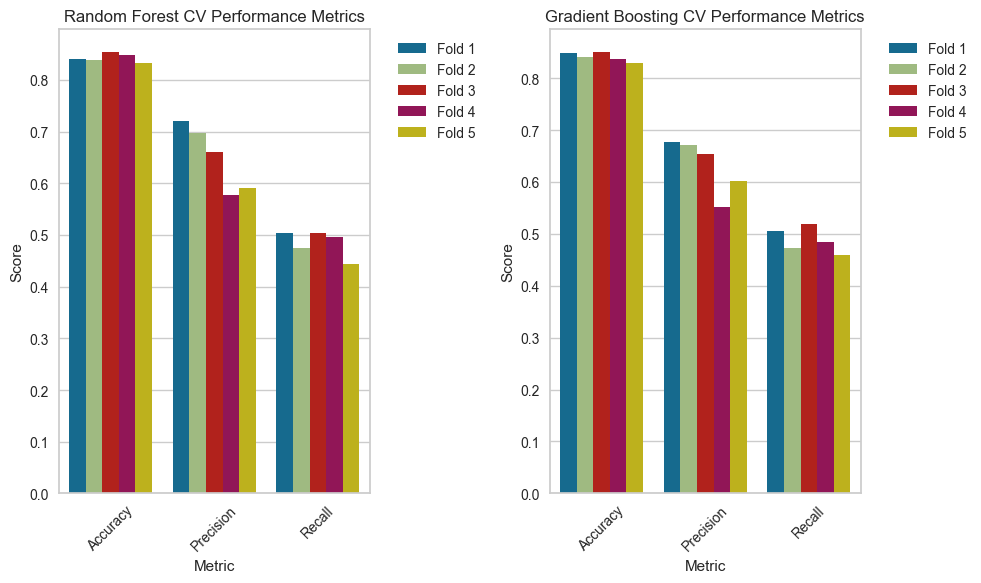

c:\Users\squaade\Documents\Github\fwi-predict\.venv\Lib\site-packages\yellowbrick\classifier\base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(
c:\Users\squaade\Documents\Github\fwi-predict\.venv\Lib\site-packages\yellowbrick\classifier\base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(
c:\Users\squaade\Documents\Github\fwi-predict\.venv\Lib\site-packages\yellowbrick\classifier\base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(
c:\Users\squaade\Documents\Github\fwi-predict\.venv\Lib\site-packages\yellowbrick\classifier\base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


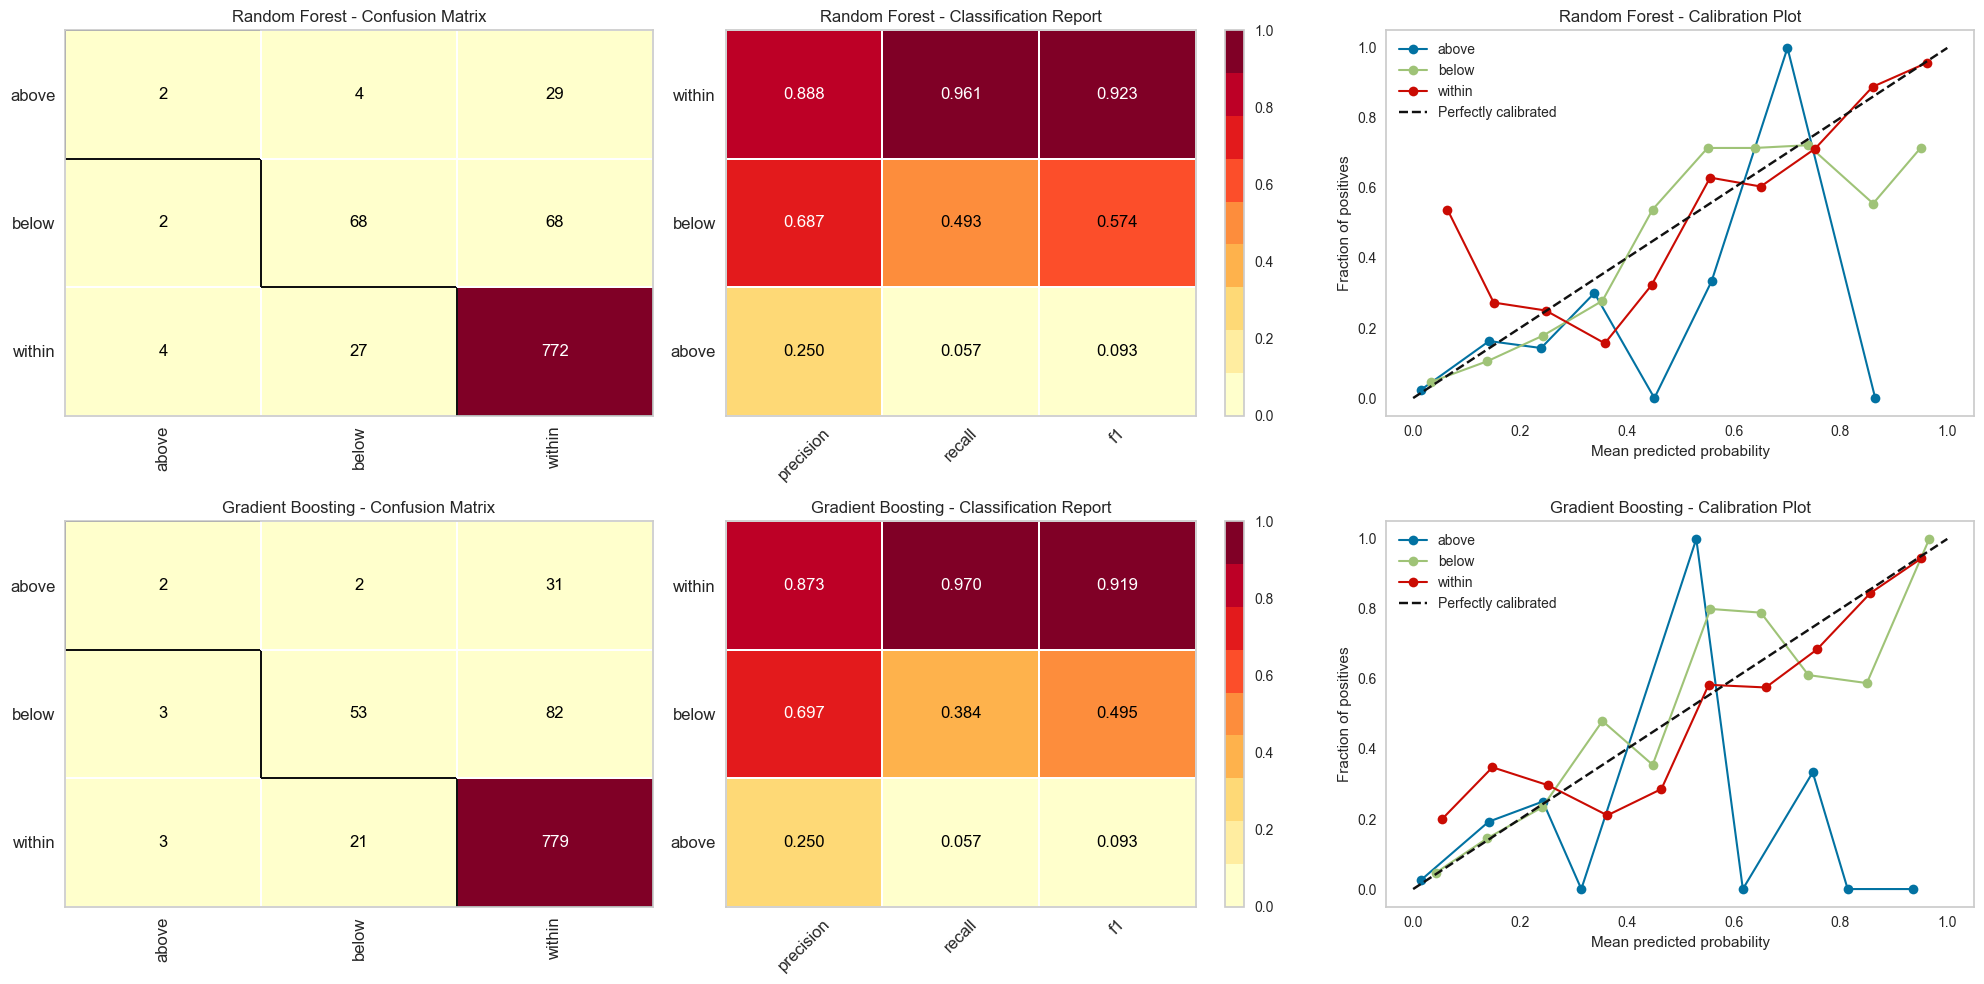


Processing target: ph_in_range


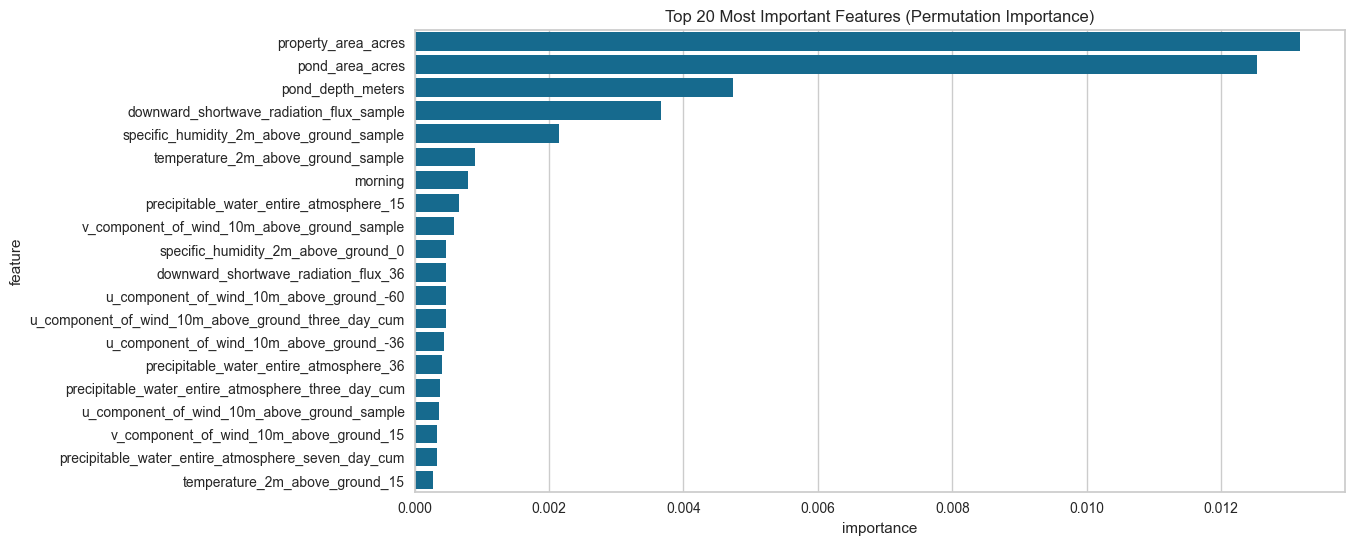


Training Random Forest...


c:\Users\squaade\Documents\Github\fwi-predict\.venv\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\squaade\Documents\Github\fwi-predict\.venv\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\squaade\Documents\Github\fwi-predict\.venv\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [17] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\squaade\Documents\Github\fwi-predict\.venv\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Best CV accuracy score: 0.924

Training Gradient Boosting...


c:\Users\squaade\Documents\Github\fwi-predict\.venv\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\squaade\Documents\Github\fwi-predict\.venv\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\squaade\Documents\Github\fwi-predict\.venv\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [17] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\squaade\Documents\Github\fwi-predict\.venv\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Best CV accuracy score: 0.921


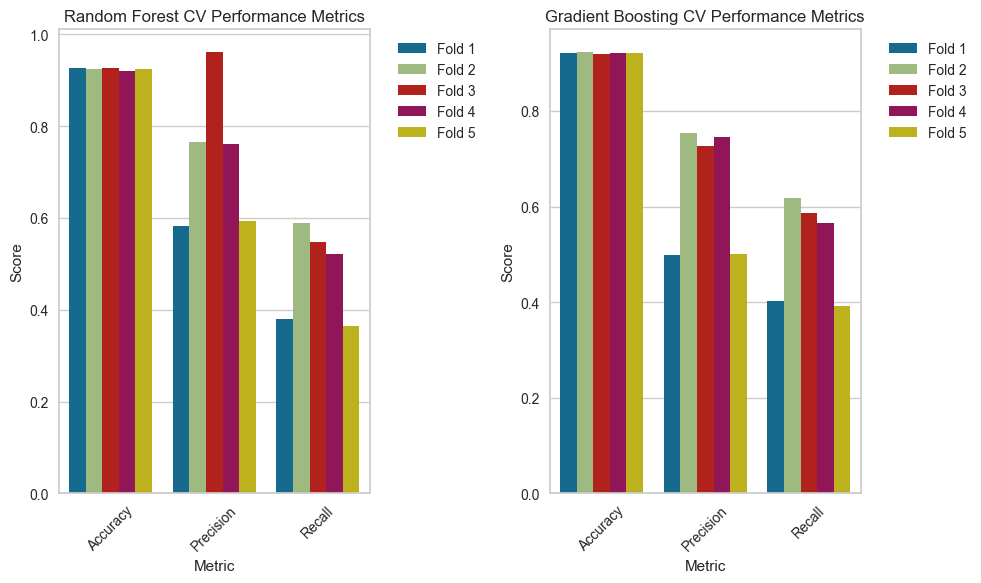

c:\Users\squaade\Documents\Github\fwi-predict\.venv\Lib\site-packages\yellowbrick\classifier\base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(
c:\Users\squaade\Documents\Github\fwi-predict\.venv\Lib\site-packages\yellowbrick\classifier\base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(
c:\Users\squaade\Documents\Github\fwi-predict\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\squaade\Documents\Github\fwi-predict\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` p

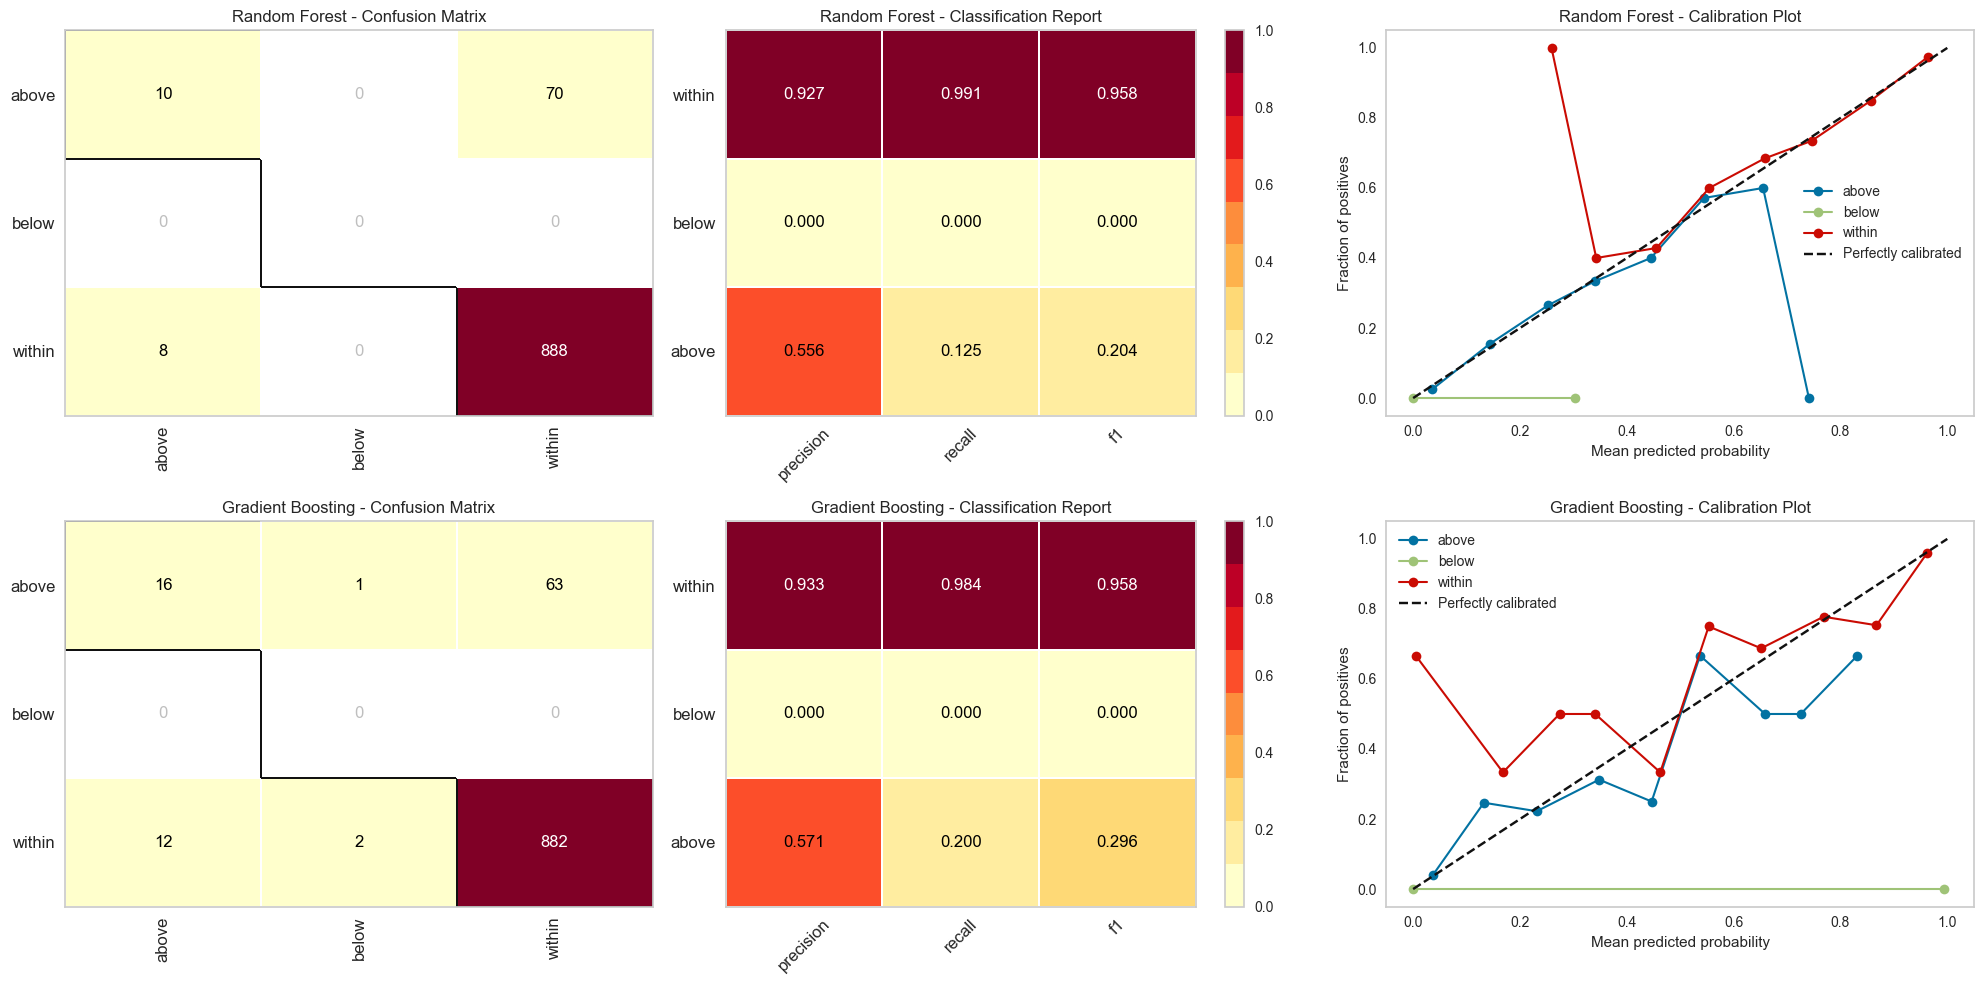


Processing target: ammonia_in_range


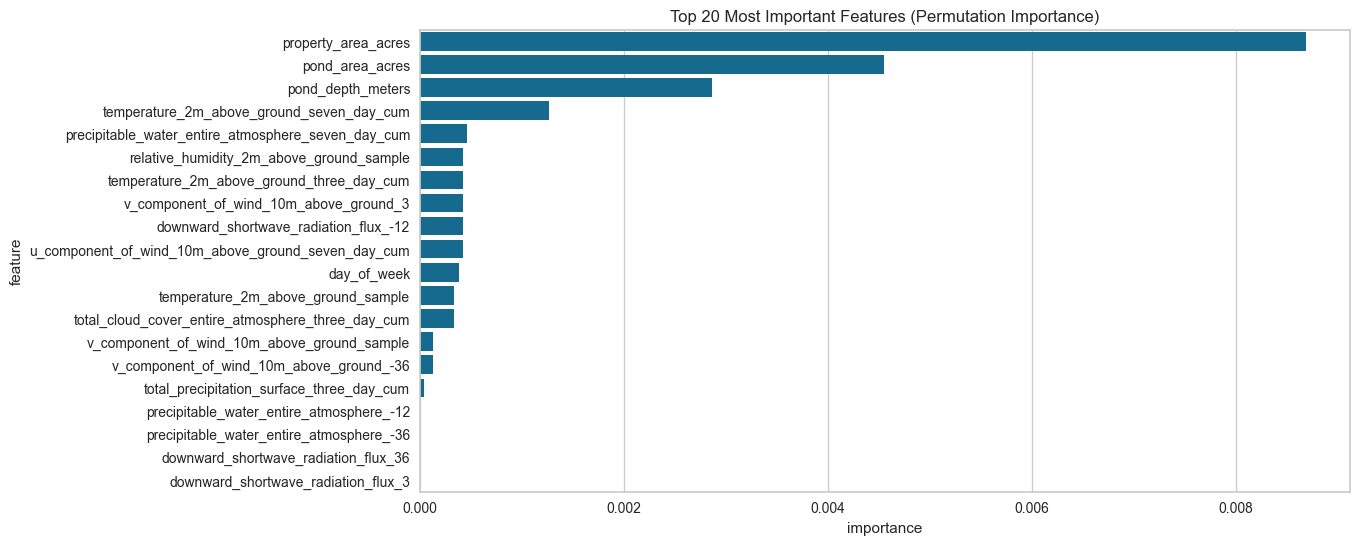


Training Random Forest...


c:\Users\squaade\Documents\Github\fwi-predict\.venv\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [11] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\squaade\Documents\Github\fwi-predict\.venv\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Best CV accuracy score: 0.970

Training Gradient Boosting...


c:\Users\squaade\Documents\Github\fwi-predict\.venv\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [11] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\squaade\Documents\Github\fwi-predict\.venv\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Best CV accuracy score: 0.971


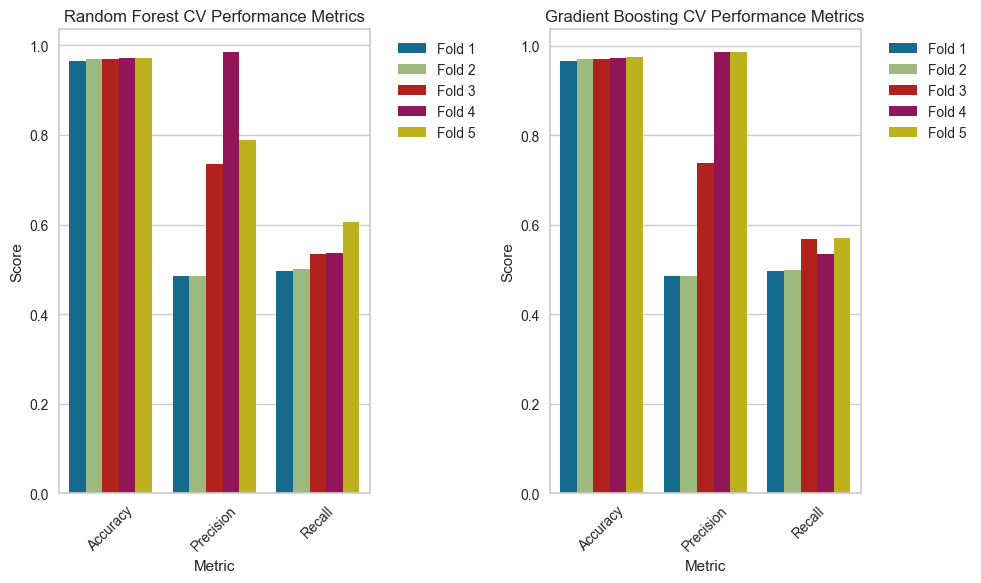

c:\Users\squaade\Documents\Github\fwi-predict\.venv\Lib\site-packages\yellowbrick\classifier\base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(
c:\Users\squaade\Documents\Github\fwi-predict\.venv\Lib\site-packages\yellowbrick\classifier\base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(
c:\Users\squaade\Documents\Github\fwi-predict\.venv\Lib\site-packages\yellowbrick\classifier\base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(
c:\Users\squaade\Documents\Github\fwi-predict\.venv\Lib\site-packages\yellowbrick\classifier\base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


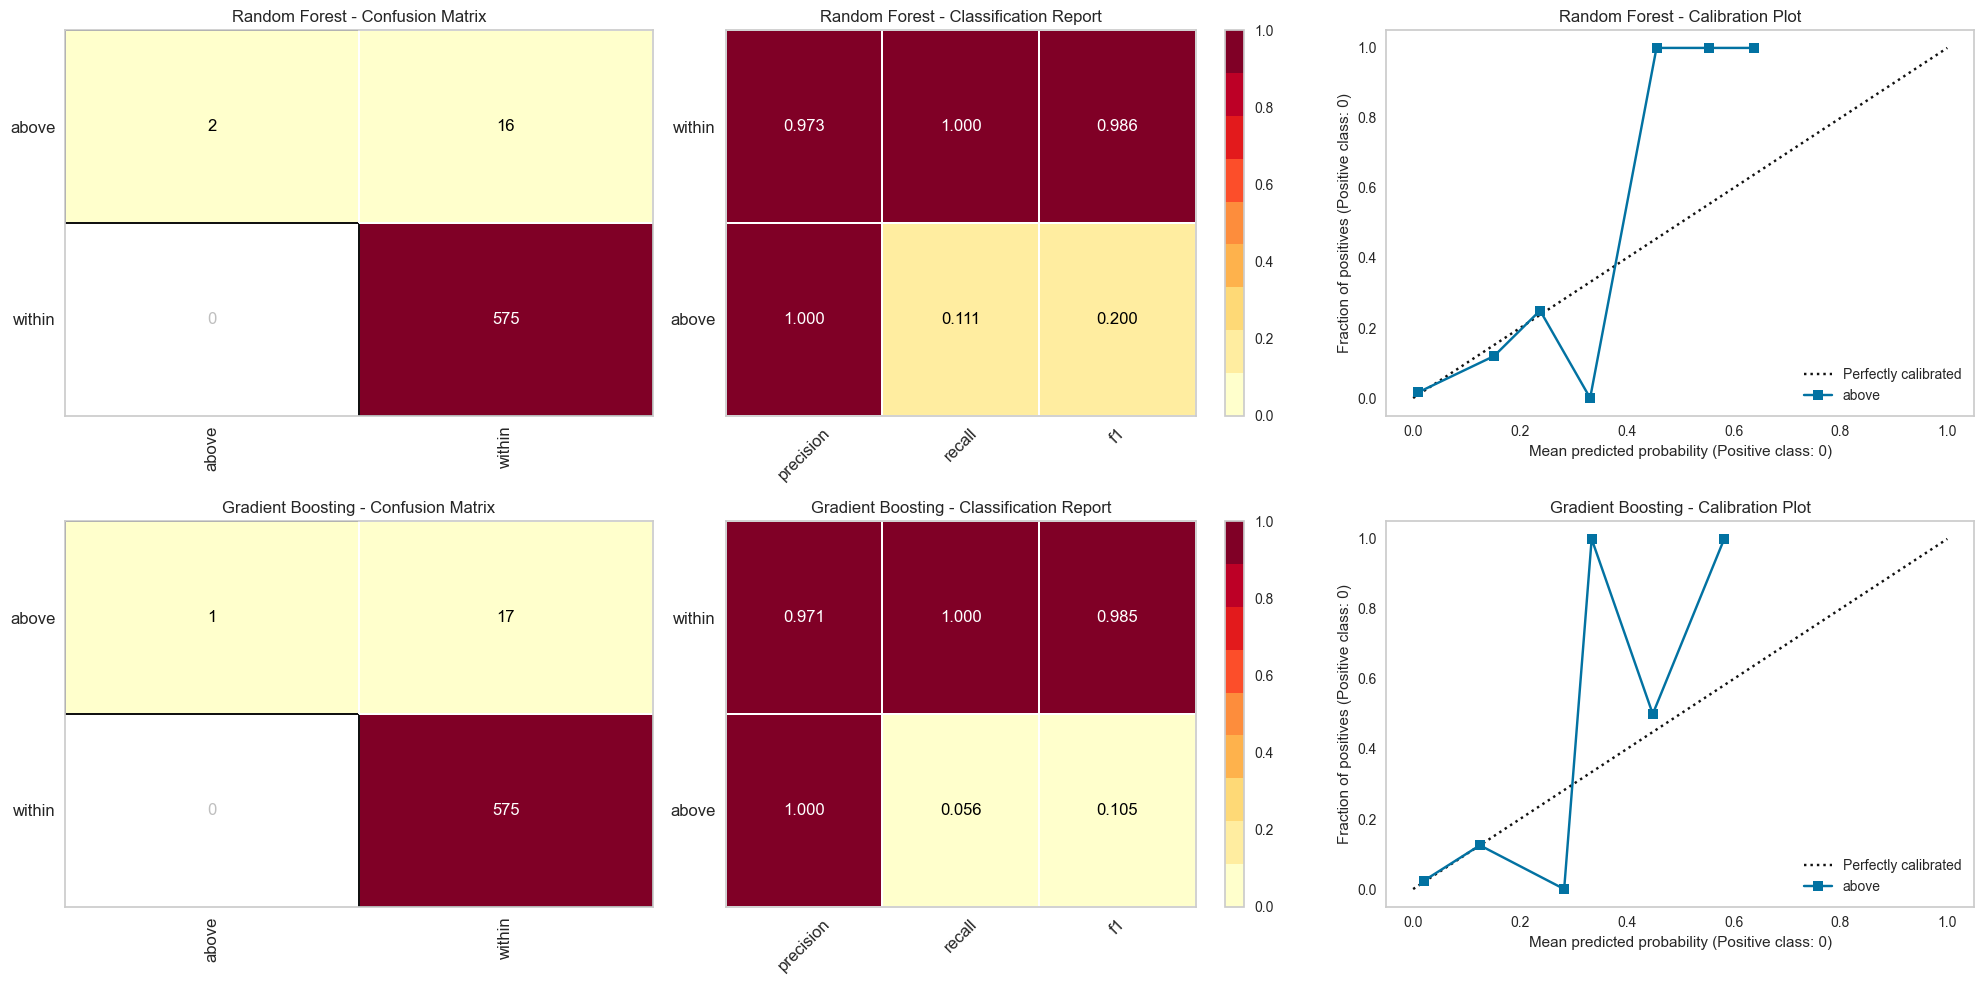


Processing target: turbidity_in_range


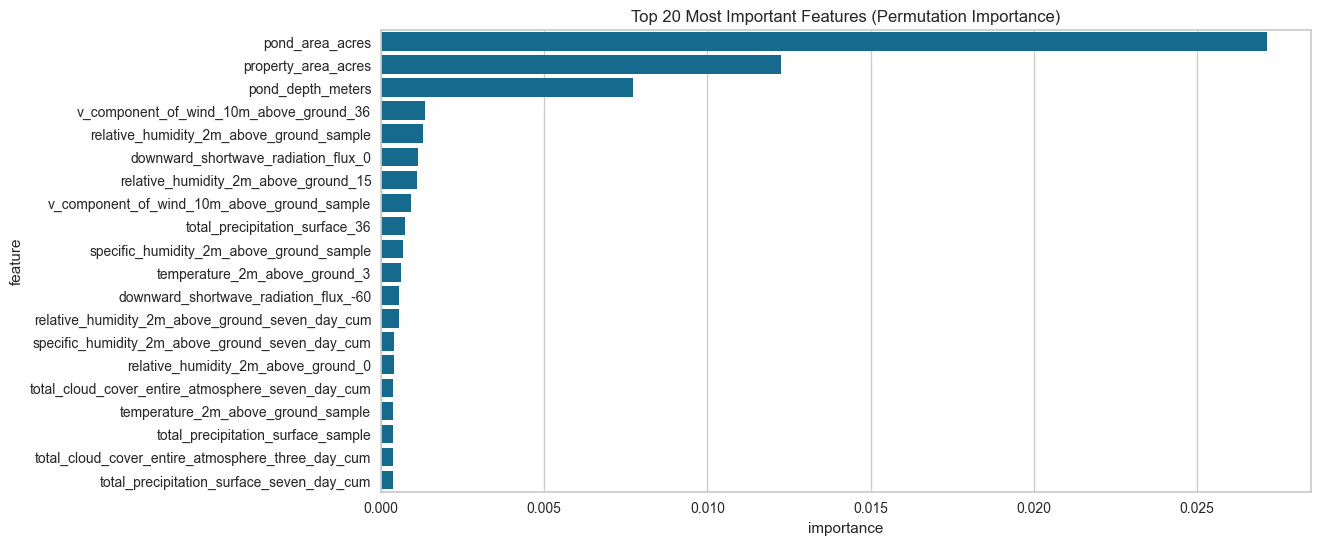


Training Random Forest...


c:\Users\squaade\Documents\Github\fwi-predict\.venv\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [17] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\squaade\Documents\Github\fwi-predict\.venv\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Best CV accuracy score: 0.918

Training Gradient Boosting...


c:\Users\squaade\Documents\Github\fwi-predict\.venv\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [17] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\squaade\Documents\Github\fwi-predict\.venv\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Best CV accuracy score: 0.913


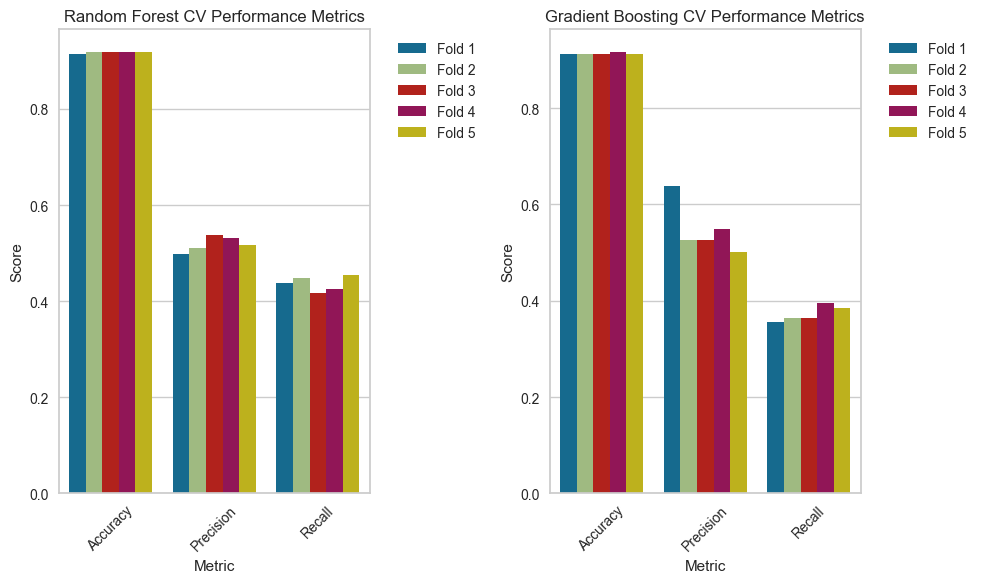

c:\Users\squaade\Documents\Github\fwi-predict\.venv\Lib\site-packages\yellowbrick\classifier\base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(
c:\Users\squaade\Documents\Github\fwi-predict\.venv\Lib\site-packages\yellowbrick\classifier\base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(
c:\Users\squaade\Documents\Github\fwi-predict\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\squaade\Documents\Github\fwi-predict\.venv\Lib\site-packages\yellowbrick\classifier\base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(
c:\Users\squaade\Doc

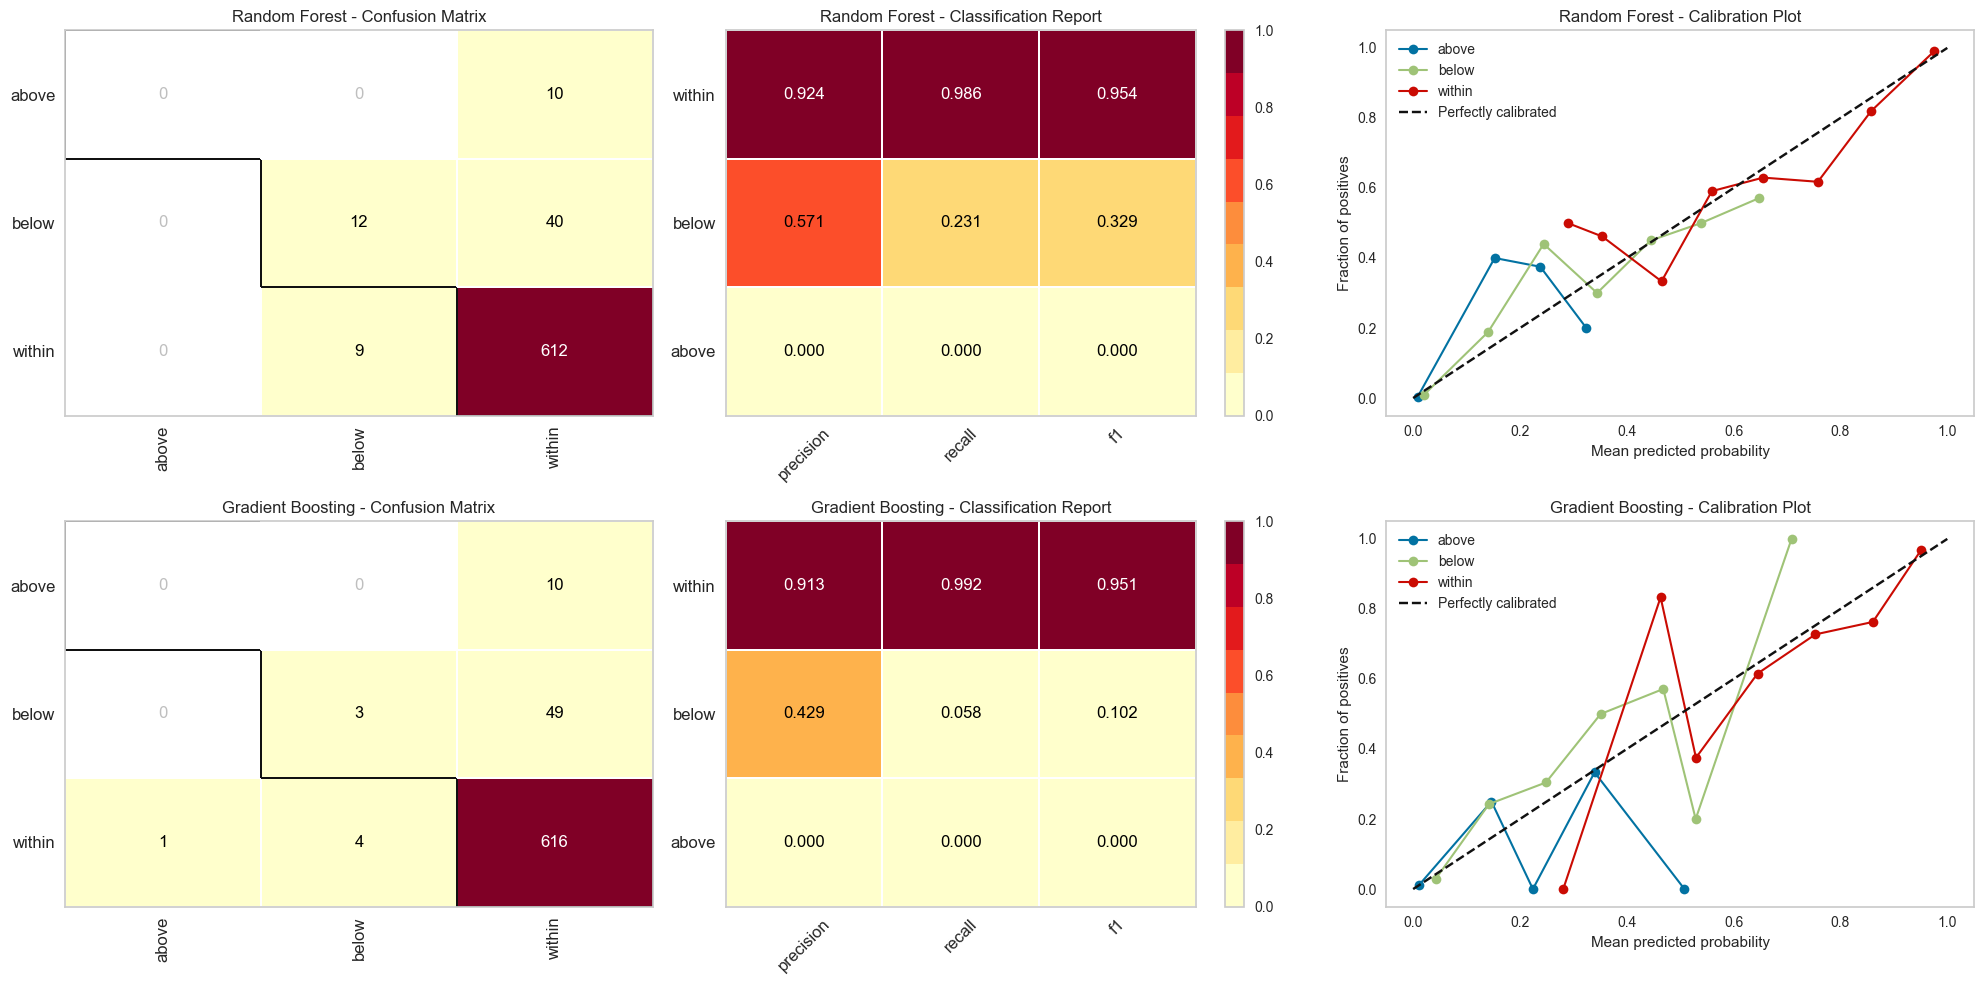

In [80]:
target_columns = ['do_in_range', 'ph_in_range', 'ammonia_in_range', 'turbidity_in_range']  # Replace with actual target column names

# Categorical encoder params
cat_vars = ['day_of_week', 'month', 'week_of_month']
feature_dtype_dict = {
  'categorical': cat_vars,
  'non_categorical': classify_df.columns[~classify_df.columns.isin(cat_vars + target_columns)].tolist()
}

# Create splits for each target
splits = create_stratified_splits(classify_df, target_columns, random_state=42)

# For each target, train and evaluate models
final_models = {}
for target in target_columns:
    print(f"\nProcessing target: {target}")
    print("=" * 50)
    
    # Get split data for current target
    split_data = splits[target]

    # Plot feature importance
    _ = plot_feature_importance(split_data['X_train'], split_data['y_train'])
    
    # Train and evaluate models
    trained_models = train_models(split_data['X_train'], split_data['y_train'], cat_vars)
    
    # Compare model performances
    compare_models(trained_models,
                   split_data['X_test'],
                   split_data['y_test'],
                   encoder=split_data['label_encoder'])
    
    # Store final models
    final_models[target] = {
      'models': trained_models,
      'encoder': split_data['label_encoder']
    }

In [81]:
from pathlib import Path
import pickle # Consider using joblib

models = {
  'do_in_range': 'Random Forest',
  'ph_in_range': 'Random Forest',
  'ammonia_in_range': 'Gradient Boosting',
  'turbidity_in_range': 'Random Forest'
}
model_dir = Path("..") / "models" / "measurements_with_metadata_simple"
model_dir.mkdir(parents=True, exist_ok=True)

for target, model_dict in final_models.items():
  target_dir = model_dir / target
  target_dir.mkdir(exist_ok=True)

  target_model = models[target]
  model = model_dict['models'][target_model]
  encoder = model_dict['encoder']

  model_fp =  target_dir / 'model.pkl'
  encoder_fp = target_dir / "encoder.pkl"

  with open(model_fp, "wb") as f:
    pickle.dump(model, f)

  with open(encoder_fp, "wb") as f:
    pickle.dump(encoder, f)
  

Dropping ['downward_shortwave_radiation_flux_3'] as they contain all zeros.
Dropping ['downward_shortwave_radiation_flux_3'] as they contain all zeros.


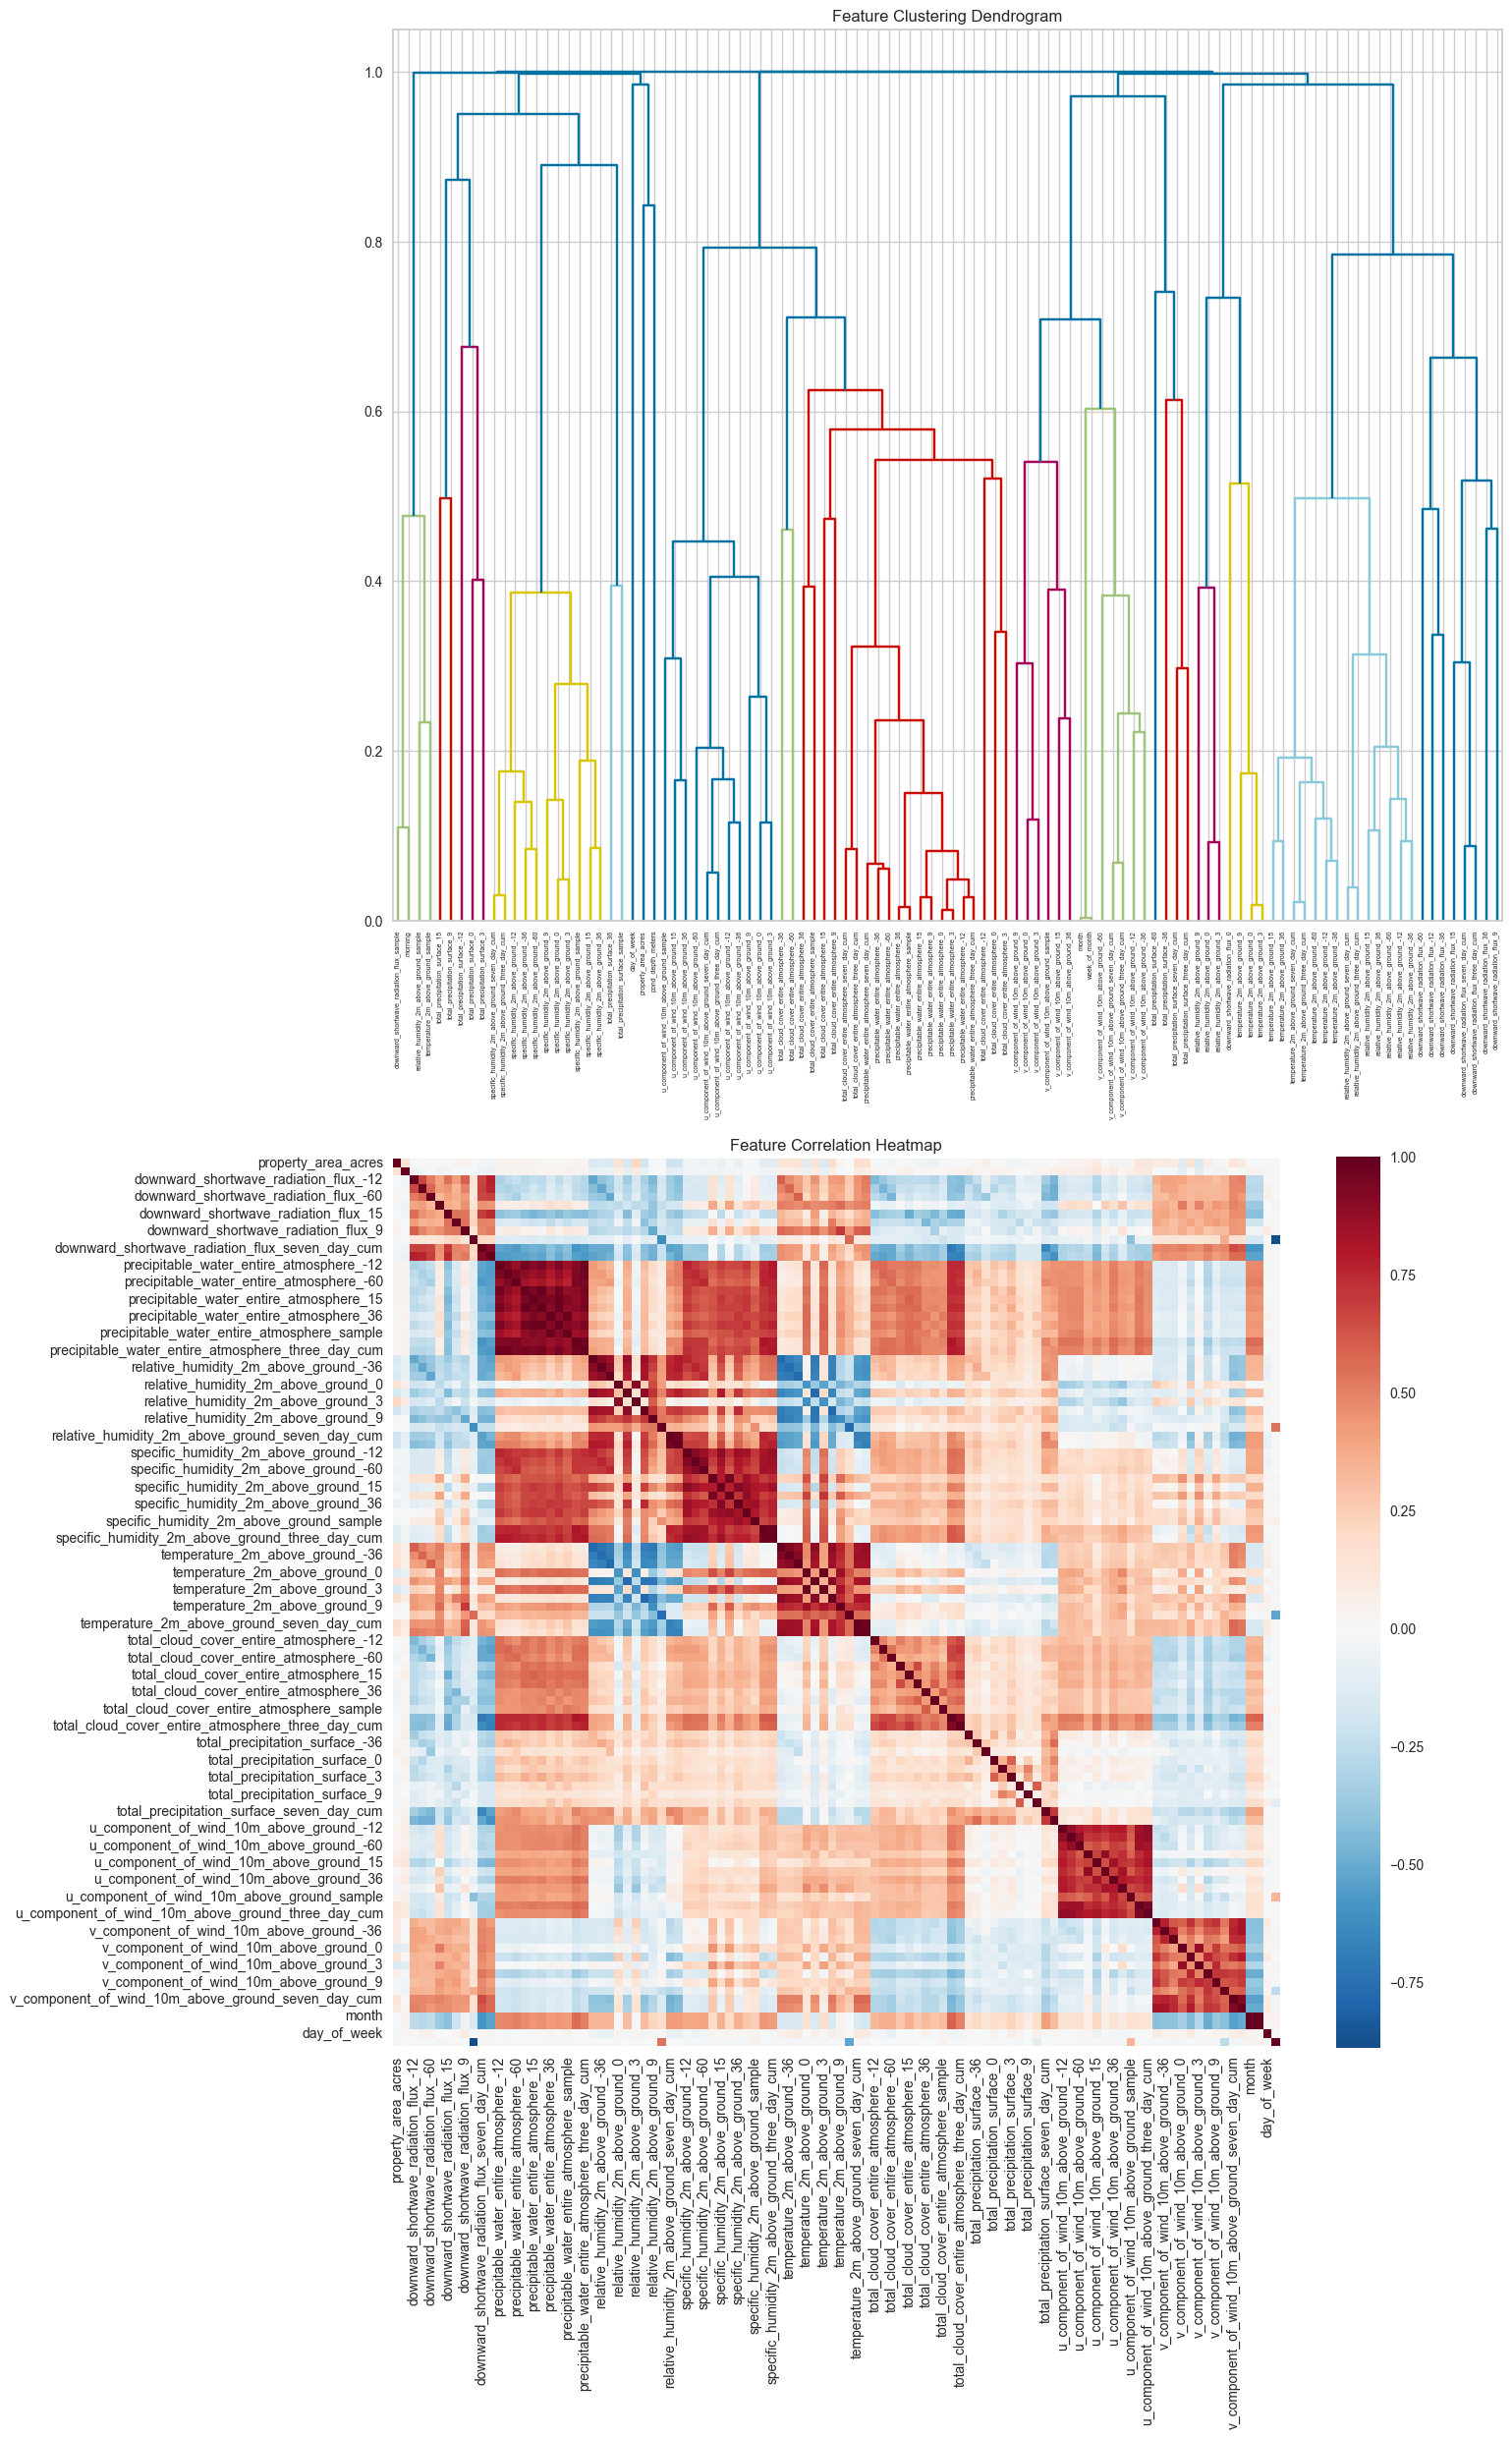


Feature Clusters (sorted by size):

Cluster 1 (6 features):
precipitable_water_entire_atmosphere_-12, precipitable_water_entire_atmosphere_0, precipitable_water_entire_atmosphere_15, precipitable_water_entire_atmosphere_3, precipitable_water_entire_atmosphere_9, precipitable_water_entire_atmosphere_three_day_cum

Cluster 2 (3 features):
precipitable_water_entire_atmosphere_-36, precipitable_water_entire_atmosphere_-60, precipitable_water_entire_atmosphere_seven_day_cum

Cluster 3 (2 features):
downward_shortwave_radiation_flux_seven_day_cum, downward_shortwave_radiation_flux_three_day_cum

Cluster 4 (2 features):
precipitable_water_entire_atmosphere_36, precipitable_water_entire_atmosphere_sample

Cluster 5 (2 features):
relative_humidity_2m_above_ground_-12, relative_humidity_2m_above_ground_-36

Cluster 6 (2 features):
relative_humidity_2m_above_ground_0, relative_humidity_2m_above_ground_3

Cluster 7 (2 features):
relative_humidity_2m_above_ground_seven_day_cum, relative_humidity_2

In [80]:
X = classify_df.drop(columns=target_columns).drop(columns='pond_area_acres')

from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform

def plot_correlation_heatmap(corr_matrix, figsize=(12, 10)):
    """Plot correlation heatmap with customized styling."""
    plt.figure(figsize=figsize)
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    
    sns.heatmap(corr_matrix, 
                mask=mask,
                cmap='RdBu_r',
                vmin=-1, 
                vmax=1, 
                center=0,
                square=True,
                annot=False,
                fmt='.2f',
                cbar_kws={"shrink": .5})
    
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

def cluster_correlated_features(X, correlation_threshold=0.9):
    """
    Cluster features based on correlation.
    
    Args:
        X (pd.DataFrame): Input features
        correlation_threshold (float): Threshold for considering features correlated
        
    Returns:
        list: List of feature clusters
    """
    # Drop columns only with zeros
    zero_cols = X.columns[X.apply(lambda col: col.eq(0).all(), axis=0)].tolist()

    if zero_cols:
      print(f"Dropping {zero_cols} as they contain all zeros.")

    keep_cols = X.columns[~X.columns.isin(zero_cols)].tolist()
    X_valid = X[keep_cols]

    # Calculate correlation matrix
    corr_matrix = X_valid.corr().abs()
    
    # Convert correlation matrix to distance matrix
    distance_matrix = 1 - corr_matrix
    
    # Perform hierarchical clustering
    linkage_matrix = hierarchy.linkage(squareform(distance_matrix), method='complete')
    
    # Cut the dendrogram to get clusters
    clusters = hierarchy.fcluster(linkage_matrix, 
                                  t=1-correlation_threshold, 
                                  criterion='distance')
    
    # Group features into clusters
    feature_clusters = {}
    for feature_idx, cluster_id in enumerate(clusters):
        if cluster_id not in feature_clusters:
            feature_clusters[cluster_id] = []
        feature_clusters[cluster_id].append(X_valid.columns[feature_idx])
    
    # Sort clusters by size in descending order
    sorted_clusters = sorted(feature_clusters.values(), key=len, reverse=True)
    
    return sorted_clusters

def plot_feature_clusters(X, clusters, figsize=(15, 25)):
    """
    Plot dendrogram of feature clusters with correlation heatmap.
    
    Args:
        X (pd.DataFrame): Input features
        clusters (list): List of feature clusters
        figsize (tuple): Figure size
    """
    # Drop columns only with zeros
    zero_cols = X.columns[X.apply(lambda col: col.eq(0).all(), axis=0)].tolist()

    if zero_cols:
      print(f"Dropping {zero_cols} as they contain all zeros.")

    keep_cols = X.columns[~X.columns.isin(zero_cols)].tolist()
    X_valid = X[keep_cols]

    # Calculate correlation matrix
    corr_matrix = X_valid.corr()
    distance_matrix = 1 - np.abs(corr_matrix)
    
    # Create linkage matrix
    linkage_matrix = hierarchy.linkage(squareform(distance_matrix), method='complete')
    
    # Create figure with subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=figsize)
    
    # Plot dendrogram
    hierarchy.dendrogram(linkage_matrix,
                         labels=X_valid.columns.tolist(),
                         leaf_rotation=90,
                         ax=ax1)
    ax1.set_title('Feature Clustering Dendrogram')
    
    # Plot correlation heatmap
    sns.heatmap(corr_matrix,
                cmap='RdBu_r',
                center=0,
                square=True,
                ax=ax2)
    ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)
    ax2.set_yticklabels(ax2.get_yticklabels(), rotation=0)
    ax2.set_title('Feature Correlation Heatmap')
    
    plt.tight_layout()
    plt.show()
    
    # Print clusters sorted by size
    print("\nFeature Clusters (sorted by size):")
    for i, cluster in enumerate(clusters, 1):
        print(f"\nCluster {i} ({len(cluster)} features):")
        print(", ".join(cluster))

# Get clusters and visualize
clusters = cluster_correlated_features(X)
plot_feature_clusters(X, clusters)

In [ ]:
# For each cluster, keep only the feature with highest correlation with target
def select_best_features_from_clusters(X, y, clusters):
    # Calculate correlation with target for all features
    target_correlations = X.corrwith(y).abs()
    
    # For each cluster, find feature with highest correlation
    selected_features = []
    for cluster in clusters:
        # Get correlations for features in this cluster
        cluster_correlations = target_correlations[cluster]
        # Select feature with highest correlation
        best_feature = cluster_correlations.idxmax()
        selected_features.append(best_feature)
        
    print(f"\nSelected {len(selected_features)} features (one from each cluster):")
    print("\n".join(selected_features))
    
    return selected_features

# Select best features
selected_features = select_best_features_from_clusters(X, y, clusters)

# Create reduced dataset with only selected features
X_reduced = X[selected_features]

print(f"\nReduced X shape: {X_reduced.shape}")


In [ ]:
# Create a custom transformer for cluster-based feature selection
from sklearn.base import BaseEstimator, TransformerMixin

class ClusterFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.selected_features_ = None
        
    def fit(self, X, y):
        # Calculate correlation matrix and cluster features
        def cluster_correlated_features(X, threshold=0.8):
            # Calculate correlation matrix
            corr_matrix = X.corr().abs()
            
            # Convert correlation matrix to distance matrix
            dist_matrix = 1 - corr_matrix
            
            # Create linkage matrix for hierarchical clustering
            linkage_matrix = linkage(squareform(dist_matrix), method='complete')
            
            # Get clusters using distance threshold
            clusters = fcluster(linkage_matrix, t=threshold, criterion='distance')
            
            # Group features into clusters
            feature_clusters = {}
            for feature_idx, cluster_id in enumerate(clusters):
                if cluster_id not in feature_clusters:
                    feature_clusters[cluster_id] = []
                feature_clusters[cluster_id].append(X.columns[feature_idx])
            
            # Convert to list of clusters
            return [cluster for cluster in feature_clusters.values()]
        
        # Get clusters
        clusters = cluster_correlated_features(X)
        
        # Calculate correlation with target for all features
        target_correlations = X.corrwith(y).abs()
        
        # For each cluster, find feature with highest correlation
        selected_features = []
        for cluster in clusters:
            # Get correlations for features in this cluster
            cluster_correlations = target_correlations[cluster]
            # Select feature with highest correlation
            best_feature = cluster_correlations.idxmax()
            selected_features.append(best_feature)
            
        self.selected_features_ = selected_features
        return self
        
    def transform(self, X):
        # Validate that fit has been called
        if self.selected_features_ is None:
            raise ValueError("ClusterFeatureSelector has not been fitted yet.")
        
        # Return dataset with only selected features
        return X[self.selected_features_]

# Example usage in a pipeline:
"""
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

pipeline = Pipeline([
    ('feature_selector', ClusterFeatureSelector()),
    ('scaler', StandardScaler()),
    ('regressor', RandomForestRegressor())
])

# Fit and predict
pipeline.fit(X_train, y_train)
predictions = pipeline.predict(X_test)
"""


In [48]:
# Check where correlation matrix is not symmetric
corr_matrix = X.corr()
distance_matrix = 1 - corr_matrix.abs()
diff = distance_matrix - distance_matrix.T
asymmetric_mask = diff > 1e-10  # Allow for small floating point differences
if asymmetric_mask.any(axis=None):
    asymmetric_pairs = np.where(asymmetric_mask)
    print("Asymmetric correlations found between:")
    for i, j in zip(*asymmetric_pairs):
        if i < j:  # Only print each pair once
            print(f"{corr_matrix.index[i]} and {corr_matrix.columns[j]}: ")
            print(f"  ({corr_matrix.index[i]}, {corr_matrix.columns[j]}) = {corr_matrix.iloc[i,j]}")
            print(f"  ({corr_matrix.columns[j]}, {corr_matrix.index[i]}) = {corr_matrix.iloc[j,i]}")
else:
    print("Correlation matrix is symmetric")

Correlation matrix is symmetric


Only missing values is pond areas